In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.io as torchio
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as tds
import pandas as pd
import PIL

from google.colab import drive
drive.mount('/content/drive')

torch.manual_seed(42)

# Address for Datasets within the Drive
truthPath = "/content/drive/My Drive/data/baseline_data/animations/anim1/4096/"
noisyPath = "/content/drive/My Drive/data/baseline_data/animations/anim1/1/"

def normalize_and_center_crop(np_array, crop_size=128):
    np_array = np_array.astype(np.float32)

    normalized_image = np_array / 255.0

    start_x = (normalized_image.shape[0] - crop_size) // 2
    start_y = (normalized_image.shape[1] - crop_size) // 2

    cropped_image = normalized_image[start_x:start_x+crop_size, start_y:start_y+crop_size]

    return cropped_image

class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, truth_dir, noisy_dir, transform=None):
        """
        transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.truth_paths = [os.path.join(truth_dir, f) for f in os.listdir(truth_dir)]
        self.noisy_paths = [os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)]
        assert len(self.truth_paths) == len(self.noisy_paths)
        self.transform = transform

    def __len__(self):
        return len(self.truth_paths)

    def __getitem__(self, idx):
      sample = [
        torchio.read_image(self.noisy_paths[idx], torchio.ImageReadMode.RGB),
        torchio.read_image(self.truth_paths[idx], torchio.ImageReadMode.RGB)]

      if (self.transform):
        sample = self.transform(sample)
        assert len(sample) == 2

      return sample

class FiltersImagesDataset(ImagesDataset):
    def __getitem__(self, idx):
      noisy = cv2.cvtColor(cv2.imread(self.noisy_paths[idx]), cv2.COLOR_BGR2RGB)
      mf = cv2.medianBlur(noisy, 3)
      nlm = cv2.fastNlMeansDenoisingColored(noisy, None, templateWindowSize=3, searchWindowSize=31)
      truth = cv2.cvtColor(cv2.imread(self.truth_paths[idx]), cv2.COLOR_BGR2RGB)

      noisy = torch.from_numpy(normalize_and_center_crop(noisy))
      mf = torch.from_numpy(normalize_and_center_crop(mf))
      nlm = torch.from_numpy(normalize_and_center_crop(nlm))
      truth = torch.from_numpy(normalize_and_center_crop(truth))

      sample = [noisy, mf, nlm, truth]
      return sample

trans128 = transforms.CenterCrop(size=128)
# ds = FiltersImagesDataset(truthPath, noisyPath, trans128)
ds = FiltersImagesDataset(truthPath, noisyPath)
data_loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


True

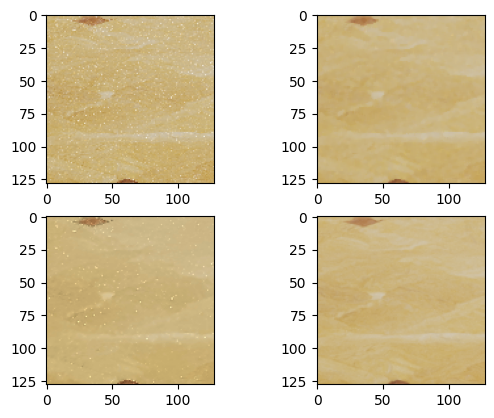

In [15]:
# Demonstrates the filters
noisy_torch, mf_torch, nlm_torch, truth_torch = next(iter(data_loader))
noisy_torch = noisy_torch[0]
mf_torch = mf_torch[0]
nlm_torch = nlm_torch[0]
truth_torch = truth_torch[0]

noisy = np.array(noisy_torch)
mf = np.array(mf_torch)
nlm = np.array(nlm_torch)
truth = np.array(truth_torch)

plt.subplot(221),plt.imshow(noisy)
plt.subplot(222),plt.imshow(mf)
plt.subplot(223),plt.imshow(nlm)
plt.subplot(224),plt.imshow(truth)

# Convert back to BGR for cv2 and revert normalization
noisy = noisy[..., ::-1] * 255
mf = mf[..., ::-1] * 255
nlm = nlm[..., ::-1] * 255
truth = truth[..., ::-1] * 255

cv2.imwrite("/content/drive/My Drive/baseline output/noisy.jpg", noisy)
cv2.imwrite("/content/drive/My Drive/baseline output/mf.jpg", mf)
cv2.imwrite("/content/drive/My Drive/baseline output/nlm.jpg", nlm)
cv2.imwrite("/content/drive/My Drive/baseline output/truth.jpg", truth)

In [16]:
criterion = nn.MSELoss()
print("Noisy vs Truth MSE: ", criterion(noisy_torch, truth_torch))
print("MF vs Truth MSE: ", criterion(mf_torch, truth_torch))
print("NLM vs Truth MSE: ", criterion(nlm_torch, truth_torch))

Noisy vs Truth MSE:  tensor(0.0010)
MF vs Truth MSE:  tensor(0.0002)
NLM vs Truth MSE:  tensor(0.0005)


In [17]:
# # Alternate MSE calculation method
# mse = np.mean(cv2.absdiff(noisy, truth) ** 2)
# print("mse: ", mse)
noisy_mse = []
mf_mse = []
nlm_mse = []
for i, sample in enumerate(data_loader):
  print("iteration: ", i)
  noisy_mse.append(float(criterion(sample[0][0], sample[3][0])))
  mf_mse.append(float(criterion(sample[1][0], sample[3][0])))
  nlm_mse.append(float(criterion(sample[2][0], sample[3][0])))


iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
itera

In [18]:
print("first noisy mse: ", noisy_mse[0])
print("first mf mse: ", mf_mse[0])
print("first nlm mse: ", nlm_mse[0])
print("average noisy mse: ", round(sum(noisy_mse) / len(noisy_mse), 5))
print("average mf mse: ", round(sum(mf_mse) / len(mf_mse), 5))
print("average nlm mse: ", round(sum(nlm_mse) / len(nlm_mse), 5))

first noisy mse:  0.0010281242430210114
first mf mse:  0.0002280983462696895
first nlm mse:  0.0005384141113609076
average noisy mse:  0.00195
average mf mse:  0.00084
average nlm mse:  0.00149


In [7]:
# # Code used to generate cropped images for progress report
# # Define the file paths of the images
# full_size_output_dir_path = "/content/drive/My Drive/baseline output/full size/"
# full_size_output_paths = [
#     full_size_output_dir_path + "noisy.jpg",
#     full_size_output_dir_path + "mf.jpg",
#     full_size_output_dir_path + "nlm.jpg",
#     full_size_output_dir_path + "truth.jpg"
# ]
# save_paths = [
#     full_size_output_dir_path + "cropped_" + "noisy.jpg",
#     full_size_output_dir_path + "cropped_" + "mf.jpg",
#     full_size_output_dir_path + "cropped_" + "nlm.jpg",
#     full_size_output_dir_path + "cropped_" + "truth.jpg"
# ]

# # Loop through each image
# for i, path in enumerate(full_size_output_paths):
#     # Load the image
#     image = cv2.imread(path)

#     # Get the dimensions of the image
#     height, width, _ = image.shape

#     # Calculate the size of each grid cell
#     cell_width = width // 4
#     cell_height = height // 4

#     # Calculate the coordinates of the crop region
#     start_x = cell_width
#     end_x = cell_width * 2
#     start_y = 0
#     end_y = cell_height

#     # Crop the image
#     cropped_image = image[start_y:end_y, start_x:end_x]

#     # Save the cropped image
#     cv2.imwrite(save_paths[i], cropped_image)


In [ ]:
# # Attempt to find best parameters for NLM
# tws = [3, 5, 7, 9, 11]
# sws = [21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]

# noisy = cv2.cvtColor(cv2.imread(noisyPath + "0001.png"), cv2.COLOR_BGR2RGB)
# truth = cv2.cvtColor(cv2.imread(truthPath + "0001.png"), cv2.COLOR_BGR2RGB)

# best = ()
# mse = np.mean(cv2.absdiff(noisy, truth) ** 2)
# for i in tws:
#   for j in sws:
#     print("try tws = ", i, "sws = ", j)
#     nlm = cv2.fastNlMeansDenoisingColored(noisy, None, templateWindowSize=i, searchWindowSize=j)
#     nlm_mse = np.mean(cv2.absdiff(nlm, truth) ** 2)
#     if (mse > nlm_mse):
#       mse = nlm_mse
#       best = (i, j)

# print(best)

# nlm = cv2.fastNlMeansDenoisingColored(noisy, None, templateWindowSize=best[0], searchWindowSize=[1])
# nlm_mse = np.mean(cv2.absdiff(nlm, truth) ** 2)
# print(nlm_mse)